Name: Nathan Dang

Partner: Charlie Poff-Webster

Date: 04/28/2020

DSCI225 - Applied Machine Learning

Instructor: Prof. Basye

# Lab 8 - Transfer Learning with Autoencoders

### Prompt:

Examine the notebook for Chapter 11, 11_training_deep_neural_networks.ipynb. You also might want to look at the notebook for chapter 10, which you've already used in lab 6.

Examine the notebook for Chapter 17, 17_autoencoders_and_gans.ipynb.

Build a new notebook for this lab. Much of the contents will probably be cut-and-paste from two chapter notebooks, 11 and 17 - that's OK. If you borrow chunks from anywhere other than the book's notebooks, be sure to document that with a link to where the code came from.

Our goal here is to explore the idea of using an autoencoder as a training aid to allow us to use much less labeled training data. To create a benchmark, use the code from chapter 11 that trains a model for MNIST fashion. Find a model and hyperparameters that do a decent job, but you don't have to spend a lot of time here.

See what happens as you reduce the amount of training data. From whatever amount you started with, reduce it by half repeatedly until you get below 100 images in your training set. Record the resulting accuracy for each amount. Since the runs on smaller amounts will be faster, you can run them for more epochs if it helps. Or just use an early stopping callback and let it run until it stops.

Now train an autoencoder following the notebook for Ch. 17 and then transfer the encoder layers into a new network that does classification. Note that so far, we haven't used any labelled data at all! Now repeatedly train just the upper layer of the classifier on the same amounts of labeled data that you used in the previous step. See section on Using Pretrained Layers in the notebook for Ch. 11 for how to "freeze" the lower layers. Optionally try unfreezing some or all of them and see what that does, too.

In addition, you should also keep progress notes, which will become part of your submission. At the bottom of your notebook, make a single text cell for these notes. Your notes should include two kinds of entries: problems and investigations. Problem entries should read like this: "I (or We) had <problem> in the cell that did <something>. I/We fixed this by <remedy>." Investigation entries should read like this: "I/We didn't understand <something>. We found an explanation at <link> (or perhaps, we talked to <person>) and now I/We understand it."

You may add other kinds of progress entries as you see fit, e.g. "I figured out a clever way to do <something>." But you should have at least 5 problem and 5 investigation entries.
    
<b>NOTE:</b> we marked checkpoints throughout our process which can be seen by the label of a progress log (i.e. "Progress Log 1," "Progress Log 2," etc) followed by a summary of what was going on on each checkpoint. The full documentation of the log can be found at the end of the notebook. 

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Get the data

For this lab, we are asked to use the Fashion MNIST dataset from keras.

Download the dataset.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train_full.dtype

dtype('uint8')

Split the full training set to validation and training sets, then scale the data by diving all entries by 255.

In [5]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
X_valid.shape

(5000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

Some visualisation of a sample of the images in the dataset.

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

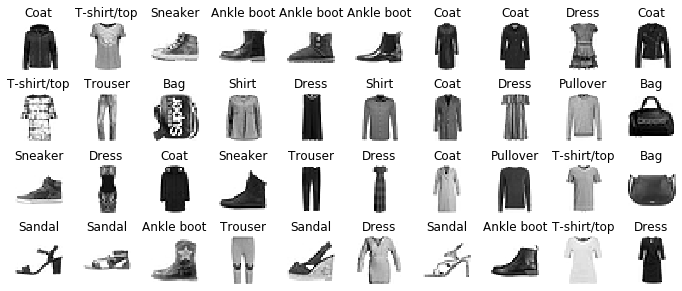

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Train a model

Train a neural network on Fashion MNIST using the ReLU activation function and Batch Normalisation:

In [10]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Progress Log 1

We defined a method that would build a model with 2 hidden 300-neuron layers, with a fixed learning rate of 2e-3. The model used Batch Normalisation and ReLU activation function.

In [11]:
def build_model(n_hidden=2, n_neurons=300, learning_rate=2e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", use_bias=False))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=["accuracy"])
    return model

In [12]:
model = build_model()

In [13]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 24s 445us/sample - loss: 0.6733 - accuracy: 0.7674 - val_loss: 0.4688 - val_accuracy: 0.8400
Epoch 2/30
55000/55000 [==============================] - 21s 381us/sample - loss: 0.4723 - accuracy: 0.8330 - val_loss: 0.4133 - val_accuracy: 0.8612
Epoch 3/30
55000/55000 [==============================] - 22s 403us/sample - loss: 0.4308 - accuracy: 0.8474 - val_loss: 0.3897 - val_accuracy: 0.8678
Epoch 4/30
55000/55000 [==============================] - 22s 399us/sample - loss: 0.4045 - accuracy: 0.8572 - val_loss: 0.3740 - val_accuracy: 0.8688
Epoch 5/30
55000/55000 [==============================] - 22s 404us/sample - loss: 0.3813 - accuracy: 0.8654 - val_loss: 0.3656 - val_accuracy: 0.8692
Epoch 6/30
55000/55000 [==============================] - 22s 400us/sample - loss: 0.3651 - accuracy: 0.8687 - val_loss: 0.3562 - val_accuracy: 0.8756
Epoch 7/30
55000/55000 [=====================

In [14]:
result = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 155us/sample - loss: 0.3415 - accuracy: 0.8814


### Progress Log 2

At this point, we were asked to reduce the amount of training data by half repeatedly until the size of the set got below 100 images. The resulting accuracy for each training amount was also recorded. 

In [34]:
X_train.shape

(55000, 28, 28)

In [35]:
accuracy_record = [] # initialise the array
accuracy_record.append(result[1]) # add the accuracy score above to the array

In [37]:
# initialise the halved training set
X_train_halved = X_train[:round(len(X_train)/2)]
y_train_halved = y_train[:round(len(y_train)/2)]

In [38]:
X_train_halved.shape

(27500, 28, 28)

The following method will train and evaluate the model on each halved training set until the length of the set gets bellow 100 images. The method returns the size of the final halved traning set as it will be needed for the next steps.

In [39]:
def testModels(X_train_halved, y_train_halved, epochNumber, i=1):
    while len(X_train_halved) > 100:
        model = build_model()
        # train and evaluate the current model
        print("\nTest #" + str(i) + "\nTraning set size = " + str(len(X_train_halved)) +  "\n")
        history = model.fit(X_train_halved, y_train_halved, epochs=epochNumber,
                        validation_data=(X_valid, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)])
        result = model.evaluate(X_test, y_test)
        print("\n-----------------------------------------------------------------------------------------------------")
        # update the training set
        X_train_halved = X_train_halved[:round(len(X_train_halved)/2)]
        y_train_halved = y_train_halved[:round(len(y_train_halved)/2)]
        # attached the accuracy score to the array
        accuracy_record.append(result[1])
        i += 1
    return len(X_train_halved)

In [40]:
# reset the model
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
epochs = 30;
previous_size = testModels(X_train_havled, y_train_halved, 30)


Test #1
Traning set size = 27500

Train on 27500 samples, validate on 5000 samples
Epoch 1/30
27500/27500 [==============================] - 5s 190us/sample - loss: 0.7985 - accuracy: 0.7287 - val_loss: 0.5373 - val_accuracy: 0.8198
Epoch 2/30
27500/27500 [==============================] - 4s 153us/sample - loss: 0.5379 - accuracy: 0.8092 - val_loss: 0.4703 - val_accuracy: 0.8388
Epoch 3/30
27500/27500 [==============================] - 4s 153us/sample - loss: 0.4747 - accuracy: 0.8321 - val_loss: 0.4355 - val_accuracy: 0.8502
Epoch 4/30
27500/27500 [==============================] - 4s 153us/sample - loss: 0.4404 - accuracy: 0.8438 - val_loss: 0.4195 - val_accuracy: 0.8560
Epoch 5/30
27500/27500 [==============================] - 4s 153us/sample - loss: 0.4212 - accuracy: 0.8526 - val_loss: 0.4074 - val_accuracy: 0.8576
Epoch 6/30
27500/27500 [==============================] - 4s 148us/sample - loss: 0.3996 - accuracy: 0.8560 - val_loss: 0.3980 - val_accuracy: 0.8590
Epoch 7/30
27500

Epoch 23/30
13750/13750 [==============================] - 2s 152us/sample - loss: 0.2674 - accuracy: 0.9077 - val_loss: 0.3854 - val_accuracy: 0.8674
Epoch 24/30
13750/13750 [==============================] - 2s 151us/sample - loss: 0.2644 - accuracy: 0.9094 - val_loss: 0.3854 - val_accuracy: 0.8682
Epoch 25/30
13750/13750 [==============================] - 2s 151us/sample - loss: 0.2584 - accuracy: 0.9115 - val_loss: 0.3858 - val_accuracy: 0.8688
Epoch 26/30
13750/13750 [==============================] - 2s 156us/sample - loss: 0.2594 - accuracy: 0.9087 - val_loss: 0.3831 - val_accuracy: 0.8684
Epoch 27/30
13750/13750 [==============================] - 2s 154us/sample - loss: 0.2462 - accuracy: 0.9136 - val_loss: 0.3832 - val_accuracy: 0.8710
Epoch 28/30
13750/13750 [==============================] - 2s 153us/sample - loss: 0.2433 - accuracy: 0.9156 - val_loss: 0.3848 - val_accuracy: 0.8700
Epoch 29/30
13750/13750 [==============================] - 2s 152us/sample - loss: 0.2405 - ac

3438/3438 [==============================] - 1s 218us/sample - loss: 0.3673 - accuracy: 0.8697 - val_loss: 0.5234 - val_accuracy: 0.8218
Epoch 15/30
3438/3438 [==============================] - 1s 212us/sample - loss: 0.3515 - accuracy: 0.8816 - val_loss: 0.5153 - val_accuracy: 0.8250
Epoch 16/30
3438/3438 [==============================] - 1s 211us/sample - loss: 0.3454 - accuracy: 0.8831 - val_loss: 0.5116 - val_accuracy: 0.8248
Epoch 17/30
3438/3438 [==============================] - 1s 216us/sample - loss: 0.3404 - accuracy: 0.8866 - val_loss: 0.5138 - val_accuracy: 0.8258
Epoch 18/30
3438/3438 [==============================] - 1s 211us/sample - loss: 0.3250 - accuracy: 0.8874 - val_loss: 0.5095 - val_accuracy: 0.8290
Epoch 19/30
3438/3438 [==============================] - 1s 212us/sample - loss: 0.3125 - accuracy: 0.8988 - val_loss: 0.5065 - val_accuracy: 0.8274
Epoch 20/30
3438/3438 [==============================] - 1s 216us/sample - loss: 0.3026 - accuracy: 0.9034 - val_loss:

860/860 [==============================] - 0s 471us/sample - loss: 0.8417 - accuracy: 0.7256 - val_loss: 1.3794 - val_accuracy: 0.6740
Epoch 6/30
860/860 [==============================] - 0s 465us/sample - loss: 0.7683 - accuracy: 0.7593 - val_loss: 1.2113 - val_accuracy: 0.6934
Epoch 7/30
860/860 [==============================] - 0s 447us/sample - loss: 0.7249 - accuracy: 0.7686 - val_loss: 1.0733 - val_accuracy: 0.7100
Epoch 8/30
860/860 [==============================] - 0s 454us/sample - loss: 0.6597 - accuracy: 0.7802 - val_loss: 0.9664 - val_accuracy: 0.7210
Epoch 9/30
860/860 [==============================] - 0s 451us/sample - loss: 0.6130 - accuracy: 0.8151 - val_loss: 0.8834 - val_accuracy: 0.7310
Epoch 10/30
860/860 [==============================] - 0s 461us/sample - loss: 0.5955 - accuracy: 0.8267 - val_loss: 0.8209 - val_accuracy: 0.7430
Epoch 11/30
860/860 [==============================] - 0s 454us/sample - loss: 0.5521 - accuracy: 0.8337 - val_loss: 0.7759 - val_accu

430/430 [==============================] - 0s 781us/sample - loss: 0.3108 - accuracy: 0.9349 - val_loss: 0.7503 - val_accuracy: 0.7574
Epoch 30/30
10000/10000 [==============================] - 0s 49us/sample - loss: 0.7733 - accuracy: 0.7384

-----------------------------------------------------------------------------------------------------

Test #8
Traning set size = 215

Train on 215 samples, validate on 5000 samples
Epoch 1/30
215/215 [==============================] - 1s 6ms/sample - loss: 2.7502 - accuracy: 0.1302 - val_loss: 2.2930 - val_accuracy: 0.1160
Epoch 2/30
215/215 [==============================] - 0s 1ms/sample - loss: 2.1247 - accuracy: 0.2837 - val_loss: 2.2340 - val_accuracy: 0.1468
Epoch 3/30
215/215 [==============================] - 0s 2ms/sample - loss: 1.6941 - accuracy: 0.4140 - val_loss: 2.1799 - val_accuracy: 0.1888
Epoch 4/30
215/215 [==============================] - 0s 2ms/sample - loss: 1.4645 - accuracy: 0.5302 - val_loss: 2.1308 - val_accuracy: 0.233

Epoch 22/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3618 - accuracy: 0.9537 - val_loss: 1.7838 - val_accuracy: 0.5134
Epoch 23/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3868 - accuracy: 0.9167 - val_loss: 1.7639 - val_accuracy: 0.5160
Epoch 24/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3536 - accuracy: 0.9537 - val_loss: 1.7425 - val_accuracy: 0.5220
Epoch 25/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.3300 - accuracy: 0.9352 - val_loss: 1.7225 - val_accuracy: 0.5234
Epoch 26/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2659 - accuracy: 0.9722 - val_loss: 1.7040 - val_accuracy: 0.5266
Epoch 27/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2895 - accuracy: 0.9537 - val_loss: 1.6845 - val_accuracy: 0.5304
Epoch 28/30
108/108 [==============================] - 0s 3ms/sample - loss: 0.2990 - accuracy: 0.9537 - val_loss: 1.6642 - val_ac

The accuracy scores of all training attemps are as follow:

In [42]:
accuracy_record

[0.8814, 0.8686, 0.8559, 0.8405, 0.8248, 0.8039, 0.7676, 0.7384, 0.644, 0.5196]

Prepare the new training set for the next steps

In [43]:
X_train_halved_final = X_train[:previous_size]
y_train_halved_final = y_train[:previous_size]

In [44]:
X_train_havled_final.shape

(54, 28, 28)

## Train a Convolutional Autoencoder

### Progress Log 3

At the point, we trained a convulutional autoencoder. Initially, the autoencoder will be trained on the full training set leaving out the labels y_train and y_valid (i.e. train the encoder on unlabelled data), just like what we were expected to do.

Define a method to plot the image of a given data point.

In [139]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

Define the image that will show the reconstruction of an image.

In [140]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Define an image for rounded accuracy using keras.

In [141]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Build and train the autoencoder.

In [142]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [144]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=["accuracy"])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 54s 980us/sample - loss: 0.3020 - accuracy: 0.5059 - val_loss: 0.2783 - val_accuracy: 0.5107
Epoch 2/5
55000/55000 [==============================] - 52s 951us/sample - loss: 0.2762 - accuracy: 0.5082 - val_loss: 0.2685 - val_accuracy: 0.5120
Epoch 3/5
55000/55000 [==============================] - 53s 960us/sample - loss: 0.2713 - accuracy: 0.5086 - val_loss: 0.2661 - val_accuracy: 0.5122
Epoch 4/5
55000/55000 [==============================] - 52s 947us/sample - loss: 0.2686 - accuracy: 0.5088 - val_loss: 0.2637 - val_accuracy: 0.5122
Epoch 5/5
55000/55000 [==============================] - 52s 948us/sample - loss: 0.2668 - accuracy: 0.5089 - val_loss: 0.2619 - val_accuracy: 0.5123


The summary of the encoder and decoder.

In [145]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

Some visualisation of the reconstructions of some images.

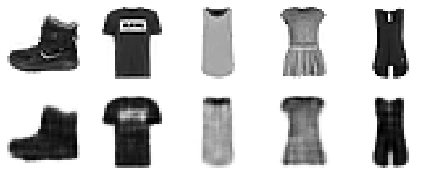

In [146]:
show_reconstructions(conv_ae)
plt.show()

## Train a regular classifier

In [191]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [192]:
classifier = build_model()

In [193]:
history = classifier.fit(X_train_halved_final, y_train_halved_final, epochs=50, 
                         validation_data=[X_valid, y_valid], 
                         callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/50
54/54 [==============================] - 1s 22ms/sample - loss: 2.9965 - accuracy: 0.0370 - val_loss: 2.3711 - val_accuracy: 0.1318
Epoch 2/50
54/54 [==============================] - 0s 5ms/sample - loss: 2.6417 - accuracy: 0.0556 - val_loss: 2.3495 - val_accuracy: 0.1336
Epoch 3/50
54/54 [==============================] - 0s 6ms/sample - loss: 2.2660 - accuracy: 0.1852 - val_loss: 2.3293 - val_accuracy: 0.1354
Epoch 4/50
54/54 [==============================] - 0s 6ms/sample - loss: 1.9993 - accuracy: 0.2593 - val_loss: 2.3094 - val_accuracy: 0.1356
Epoch 5/50
54/54 [==============================] - 0s 6ms/sample - loss: 1.6522 - accuracy: 0.3704 - val_loss: 2.2920 - val_accuracy: 0.1366
Epoch 6/50
54/54 [==============================] - 0s 5ms/sample - loss: 1.4445 - accuracy: 0.5556 - val_loss: 2.2771 - val_accuracy: 0.1370
Epoch 7/50
54/54 [==============================] - 0s 6ms/sample - loss: 1.4252 - accuracy: 0.5000 -

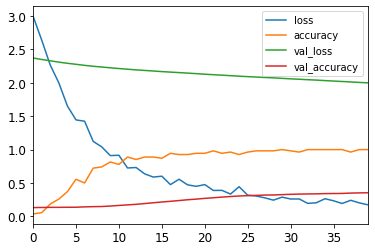

In [194]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [195]:
classifier.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 53us/sample - loss: 2.0011 - accuracy: 0.3461


[2.0010685543060305, 0.3461]

## Transfer the auto encoder layers

In [181]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [182]:
conv_encoder_clone = keras.models.clone_model(conv_encoder)

In [183]:
def build_model_ae(auto_encoder, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(auto_encoder)
    model.add(keras.layers.Flatten(input_shape=input_shape))
    keras.layers.Dense(20, activation="relu")
    model.add(keras.layers.Dense(10, activation="softmax")) 
    return model

In [184]:
pretrained_clf = build_model_ae(conv_encoder_clone)

In [185]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr=0.02),
          metrics=["accuracy"])

In [186]:
history = pretrained_clf.fit(X_train_halved_final, y_train_halved_final, epochs=20,
                             validation_data=[X_valid, y_valid],
                             callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/20
54/54 [==============================] - 1s 25ms/sample - loss: 2.3962 - accuracy: 0.0556 - val_loss: 2.3625 - val_accuracy: 0.0948
Epoch 2/20
54/54 [==============================] - 1s 18ms/sample - loss: 2.3584 - accuracy: 0.0741 - val_loss: 2.3447 - val_accuracy: 0.0732
Epoch 3/20
54/54 [==============================] - 1s 18ms/sample - loss: 2.3258 - accuracy: 0.0741 - val_loss: 2.3294 - val_accuracy: 0.0880
Epoch 4/20
54/54 [==============================] - 1s 19ms/sample - loss: 2.2968 - accuracy: 0.1481 - val_loss: 2.3162 - val_accuracy: 0.1002
Epoch 5/20
54/54 [==============================] - 1s 18ms/sample - loss: 2.2689 - accuracy: 0.1667 - val_loss: 2.3048 - val_accuracy: 0.1012
Epoch 6/20
54/54 [==============================] - 1s 18ms/sample - loss: 2.2447 - accuracy: 0.1852 - val_loss: 2.2944 - val_accuracy: 0.1068
Epoch 7/20
54/54 [==============================] - 1s 17ms/sample - loss: 2.2262 - accuracy: 0.

In [187]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr=0.02),
          metrics=["accuracy"])

In [188]:
history = pretrained_clf.fit(X_train_halved_final, y_train_halved_final, epochs=30,
                             validation_data=[X_valid, y_valid],
                             callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)])

Train on 54 samples, validate on 5000 samples
Epoch 1/30
54/54 [==============================] - 2s 32ms/sample - loss: 2.0439 - accuracy: 0.2963 - val_loss: 2.2045 - val_accuracy: 0.2290
Epoch 2/30
54/54 [==============================] - 1s 19ms/sample - loss: 1.9883 - accuracy: 0.3704 - val_loss: 2.1897 - val_accuracy: 0.2624
Epoch 3/30
54/54 [==============================] - 1s 19ms/sample - loss: 1.9336 - accuracy: 0.3889 - val_loss: 2.1641 - val_accuracy: 0.3024
Epoch 4/30
54/54 [==============================] - 1s 19ms/sample - loss: 1.8921 - accuracy: 0.4074 - val_loss: 2.1497 - val_accuracy: 0.3132
Epoch 5/30
54/54 [==============================] - 1s 18ms/sample - loss: 1.8390 - accuracy: 0.4815 - val_loss: 2.1383 - val_accuracy: 0.3168
Epoch 6/30
54/54 [==============================] - 1s 19ms/sample - loss: 1.7985 - accuracy: 0.4444 - val_loss: 2.0993 - val_accuracy: 0.3500
Epoch 7/30
54/54 [==============================] - 1s 19ms/sample - loss: 1.7710 - accuracy: 0.

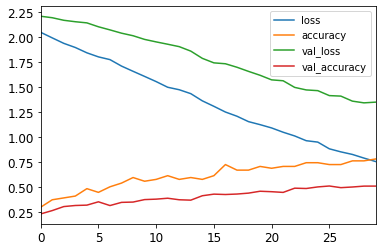

In [189]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [190]:
pretrained_clf.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 203us/sample - loss: 1.3643 - accuracy: 0.5031


[1.3642520025253295, 0.5031]

## Progress Log

1. We acknowledged that we had to make a bunch of training attempts for some particular steps throughout the lab, and the build_model() method saved us the trouble of having to copy the same chunk of code multiple times. We defined the method based on the one in chapter 10 (under Hyperparameter Tuning section), and at first, we ran into a bit troubles as we received some errors while trying to call the method. Obviously, we could not use the same chunk of code in chapter 10 as we were building a different model; therefore, we had to make some changes to the code. But after staring at it for a while, we figured out the problem, that is, the code in chapter 10 used loss="mse" while we needed to use loss="sparse_categorical_crossentropy" instead. 

2. We defined a method that ran all of the training attemps with different size of the training set, again, to save us the trouble from copying the same block of code over and over again. The accuracy scores throughout the attempts did decrease as the training size was halved on each iteration, exactly like what we expected. After this step, we ended up with a training size of 58 which is obviously less than 100, but we were wondering if this number was too small...  

3. [talk about some problems of choosing what kind of autoencoder to use]